## Load the Data

In [2]:
import pandas as pd

In [3]:
# Load feature names
features = pd.read_csv("UCI HAR Dataset/features.txt", sep="\\s+", header=None, names=["index", "feature"])
feature_names = features["feature"].values

In [4]:
# Load activity labels
activity_labels = pd.read_csv("UCI HAR Dataset/activity_labels.txt", sep="\\s+", header=None, names=["Activity_ID", "Activity"])

In [5]:
# Load training data
X_train = pd.read_csv("UCI HAR Dataset/train/X_train.txt", sep="\\s+", header=None, names=["feature_names"])
y_train = pd.read_csv("UCI HAR Dataset/train/y_train.txt", sep="\\s+", header=None, names=["Activity"])
subject_train = pd.read_csv("UCI HAR Dataset/train/subject_train.txt", sep="\\s+", header=None, names=["Subject"])


In [6]:
# Load test data
X_test = pd.read_csv("UCI HAR Dataset/test/X_test.txt", sep="\\s+", header=None, names=["feature_names"])
y_test = pd.read_csv("UCI HAR Dataset/test/y_test.txt", sep="\\s+", header=None, names=["Activity"])
subject_test = pd.read_csv("UCI HAR Dataset/test/subject_test.txt", sep="\\s+", header=None, names=["Subject"])


In [7]:
# Combine train and test sets
X = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)
y = pd.concat([y_train, y_test], axis=0).reset_index(drop=True)
subjects = pd.concat([subject_train, subject_test], axis=0).reset_index(drop=True)


In [8]:
# Merge all data into a single DataFrame
df = pd.concat([subjects, X, y], axis=1)

In [9]:
# Map activity labels
df["Activity"] = df["Activity"].map(dict(zip(activity_labels["Activity_ID"], activity_labels["Activity"])))


In [10]:
# Display basic info
print(df.head())
print(df.info())

   Subject  feature_names  Activity
0        1      -0.058627  STANDING
1        1      -0.054317  STANDING
2        1      -0.049118  STANDING
3        1      -0.047663  STANDING
4        1      -0.043892  STANDING
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10299 entries, 0 to 10298
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Subject        10299 non-null  int64  
 1   feature_names  10299 non-null  float64
 2   Activity       10299 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 241.5+ KB
None


## Check for Missing Values & Data Types

In [12]:
# Check for missing values
print(df.isnull().sum().sum())  # Should be 0 if no missing values

0


In [13]:
# Check data types
print(df.dtypes)

Subject            int64
feature_names    float64
Activity          object
dtype: object


## Basic Statistical Analysis

In [15]:
# Summary statistics
print(df.describe())

            Subject  feature_names
count  10299.000000   10299.000000
mean      16.146422      -0.054284
std        8.679067       0.268898
min        1.000000      -1.000000
25%        9.000000      -0.131880
50%       17.000000      -0.003882
75%       24.000000       0.102970
max       30.000000       1.000000


In [16]:
# Count of each activity
print(df["Activity"].value_counts())

Activity
LAYING                1944
STANDING              1906
SITTING               1777
WALKING               1722
WALKING_UPSTAIRS      1544
WALKING_DOWNSTAIRS    1406
Name: count, dtype: int64


## Data Visualization

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

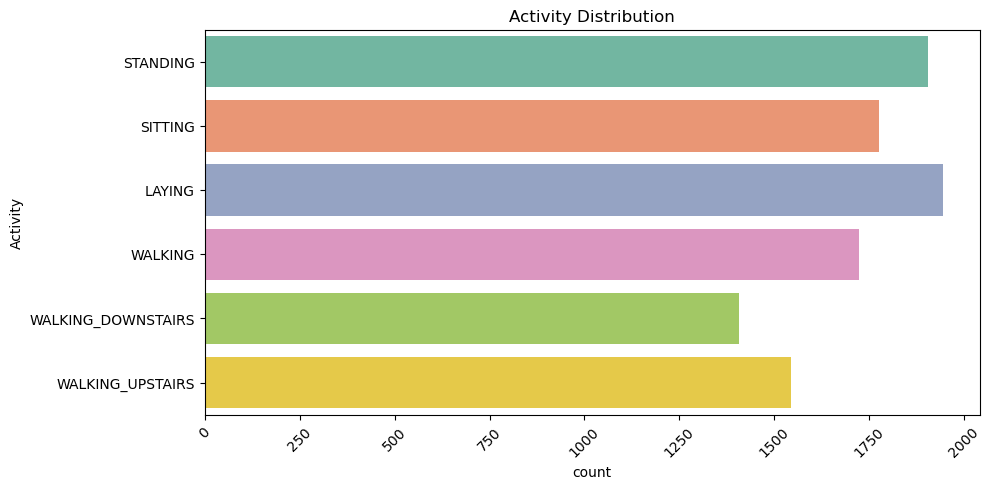

In [19]:
# Check activity distribution
plt.figure(figsize=(10, 5))
sns.countplot(y="Activity", data=df, hue="Activity", palette="Set2", legend=False)
plt.xticks(rotation=45)
plt.title("Activity Distribution")
plt.show()

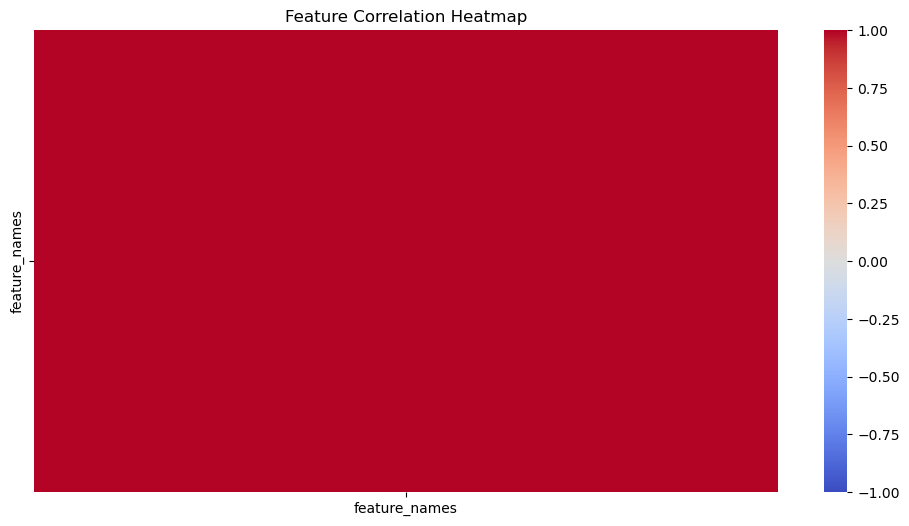

In [20]:
plt.figure(figsize=(12, 6))
sns.heatmap(X.corr(), cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Feature Correlation Heatmap")
plt.show()

## Feature Selection

In [22]:
# Find highly correlated features (correlation > 0.9)
corr_matrix = X.corr().abs()
high_corr_features = [column for column in corr_matrix.columns if any(corr_matrix[column] > 0.9)]
print("Highly Correlated Features:", high_corr_features)


Highly Correlated Features: ['feature_names']


## Principal Component Analysis (PCA)

In [24]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [25]:
# Scale the data
scaler = StandardScaler()

In [26]:
X_train = pd.read_csv("UCI HAR Dataset/train/X_train.txt", sep="\\s+", header=None)
X_test = pd.read_csv("UCI HAR Dataset/test/X_test.txt", sep="\\s+", header=None)
X = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)

In [27]:
X_scaled = scaler.fit_transform(X)
X_scaled.shape

(10299, 561)

In [28]:
# Convert activity labels to numerical categories
df["Activity_Code"] = df["Activity"].astype("category").cat.codes

In [29]:
# Use min(2, total features) to avoid errors
n_components = min(2, X_scaled.shape[1])
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

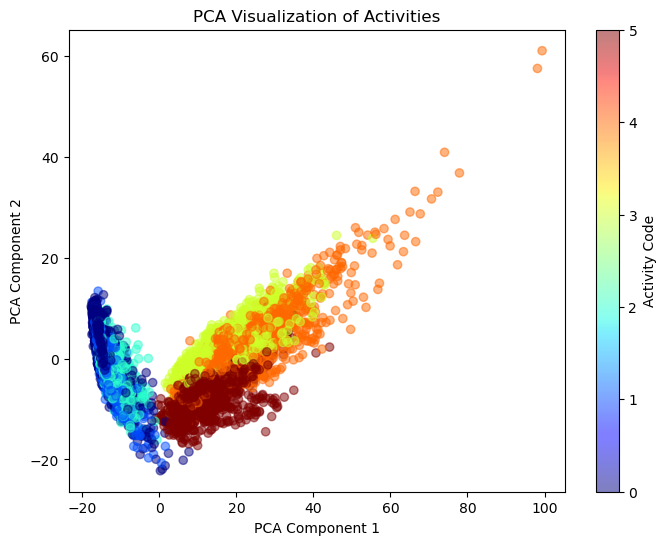

In [30]:
# Plot PCA scatter with numeric color mapping
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df["Activity_Code"], cmap="jet", alpha=0.5)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Visualization of Activities")
plt.colorbar(label="Activity Code")  # Shows color mapping
plt.show()

## Prepare Features and Labels

In [32]:
# Prepare features and labels for model training
X_features = df.drop(columns=["Subject", "Activity", "Activity_Code"])
y_labels = df["Activity"]

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.2, stratify=y_labels, random_state=42)

In [35]:
# !conda install -n py_env -c conda-forge xgboost -y

## Train & Evaluate Random Forest, XGBoost, SVM

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [38]:
# Encode activity labels
label_encoder = LabelEncoder()
y_labels_encoded = label_encoder.fit_transform(y_labels)

In [39]:
# Split the encoded labels instead
X_train, X_test, y_train, y_test = train_test_split(
    X_features, y_labels_encoded, test_size=0.2, stratify=y_labels_encoded, random_state=42
)

In [40]:
# Models to compare
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    "SVM": SVC(kernel='rbf', C=1.0, gamma='scale')
}

In [41]:
# Training and evaluation loop
for name, model in models.items():
    print(f"\n=== {name} ===")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))


=== Random Forest ===
Accuracy: 0.4015
              precision    recall  f1-score   support

           0       0.78      0.81      0.79       389
           1       0.44      0.43      0.43       356
           2       0.31      0.29      0.30       381
           3       0.26      0.28      0.27       344
           4       0.23      0.23      0.23       281
           5       0.29      0.28      0.29       309

    accuracy                           0.40      2060
   macro avg       0.38      0.39      0.39      2060
weighted avg       0.40      0.40      0.40      2060


=== XGBoost ===


C:\Users\Kajal\anaconda3\envs\py_env\lib\site-packages\xgboost\core.py:158: UserWarning: [17:27:33] WARNING: D:\bld\xgboost-split_1744329010901\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.4684
              precision    recall  f1-score   support

           0       0.87      0.82      0.85       389
           1       0.53      0.47      0.50       356
           2       0.33      0.44      0.38       381
           3       0.33      0.50      0.39       344
           4       0.30      0.14      0.19       281
           5       0.45      0.33      0.38       309

    accuracy                           0.47      2060
   macro avg       0.47      0.45      0.45      2060
weighted avg       0.48      0.47      0.46      2060


=== SVM ===
Accuracy: 0.4393
              precision    recall  f1-score   support

           0       0.93      0.77      0.84       389
           1       0.61      0.47      0.53       356
           2       0.28      0.62      0.38       381
           3       0.26      0.34      0.29       344
           4       0.00      0.00      0.00       281
           5       0.52      0.28      0.37       309

    accuracy                  

C:\Users\Kajal\anaconda3\envs\py_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Kajal\anaconda3\envs\py_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Kajal\anaconda3\envs\py_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


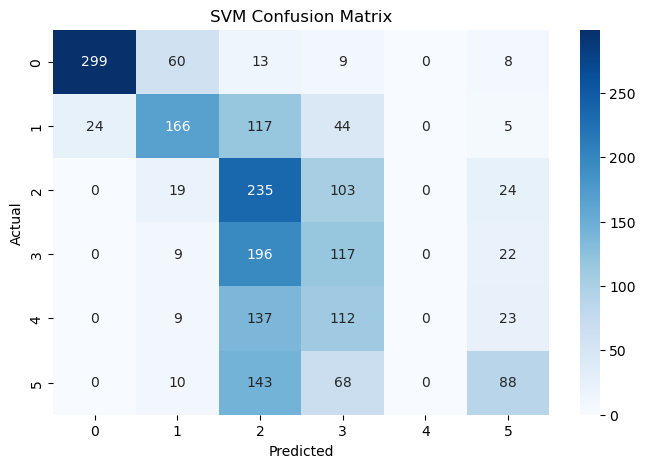

In [42]:
# Confusion Matrix
plt.figure(figsize=(8, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d",
            xticklabels=model.classes_ if hasattr(model, "classes_") else y_labels.unique(),
            yticklabels=model.classes_ if hasattr(model, "classes_") else y_labels.unique(),
            cmap="Blues")
plt.title(f"{name} Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Cross-Validation & Hyperparameter Tuning

In [44]:
from sklearn.model_selection import GridSearchCV

In [45]:
# Random Forest param grid
rf_params = {
    "n_estimators": [50, 100],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5]
}

In [46]:
# XGBoost param grid
xgb_params = {
    "n_estimators": [50, 100],
    "max_depth": [3, 6],
    "learning_rate": [0.1, 0.01]
}

In [47]:
# Grid search
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5, scoring="accuracy", n_jobs=-1)
rf_grid.fit(X_train, y_train)
print("Best RF Params:", rf_grid.best_params_)
print("Best CV Accuracy (RF):", rf_grid.best_score_)

xgb_grid = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
                        xgb_params, cv=5, scoring="accuracy", n_jobs=-1)
xgb_grid.fit(X_train, y_train)
print("Best XGB Params:", xgb_grid.best_params_)
print("Best CV Accuracy (XGB):", xgb_grid.best_score_)

Best RF Params: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
Best CV Accuracy (RF): 0.472387718770816


C:\Users\Kajal\anaconda3\envs\py_env\lib\site-packages\xgboost\core.py:158: UserWarning: [17:28:10] WARNING: D:\bld\xgboost-split_1744329010901\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best XGB Params: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 50}
Best CV Accuracy (XGB): 0.4647412771676659


## Evaluation of Best Models

In [49]:
# Evaluate best models
for name, model in [("Random Forest", rf_grid.best_estimator_), ("XGBoost", xgb_grid.best_estimator_)]:
    print(f"\n{name} Test Evaluation:")
    y_pred = model.predict(X_test)
    print("Test Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))


Random Forest Test Evaluation:
Test Accuracy: 0.46747572815533983
              precision    recall  f1-score   support

           0       0.86      0.80      0.83       389
           1       0.53      0.46      0.49       356
           2       0.34      0.48      0.40       381
           3       0.32      0.49      0.39       344
           4       0.35      0.14      0.19       281
           5       0.45      0.31      0.37       309

    accuracy                           0.47      2060
   macro avg       0.48      0.45      0.45      2060
weighted avg       0.49      0.47      0.46      2060


XGBoost Test Evaluation:
Test Accuracy: 0.4771844660194175
              precision    recall  f1-score   support

           0       0.89      0.82      0.85       389
           1       0.59      0.45      0.51       356
           2       0.33      0.49      0.39       381
           3       0.33      0.50      0.40       344
           4       0.39      0.13      0.19       281
     

##  Remove Highly Correlated Features 

In [51]:
# Remove highly correlated features (if needed)
X_filtered = X.drop(columns=[col for col in high_corr_features if col in X.columns])
X_filtered.shape

(10299, 561)

 ## Standardize the Data

In [53]:
# Convert back to DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled_df.head()

,0,1,2,3,4,5,6,7,8,9,...,551,552,553,554,555,556,557,558,559,560
0,0.210534,-0.068703,-0.452195,-0.883335,-0.945431,-0.744387,-0.874687,-0.944877,-0.773250,-0.868773,...,-0.819093,-0.000264,-0.299902,-0.357898,0.062039,-0.782988,-0.019034,-0.674432,0.382008,-0.016151
1,0.060208,0.035902,-0.275222,-0.890098,-0.929817,-0.860322,-0.883627,-0.927796,-0.858859,-0.884263,...,0.127803,-0.925905,-0.789555,0.135993,-0.022538,-1.217721,1.470315,-0.681360,0.383148,-0.000121
2,0.078460,-0.046427,-0.085548,-0.883565,-0.913598,-0.906457,-0.878093,-0.904569,-0.908437,-0.876139,...,1.172610,-0.287824,-0.461181,-0.375145,0.391762,0.134732,1.686961,-0.689471,0.384289,0.019214
3,0.071375,-0.227794,-0.270741,-0.885188,-0.946015,-0.935521,-0.879495,-0.943980,-0.938095,-0.876139,...,1.132149,0.566244,0.436736,-0.132194,-0.034739,1.010013,-0.982261,-0.688915,0.388536,0.024624
4,0.033738,0.031617,-0.121380,-0.889855,-0.940846,-0.935041,-0.882451,-0.937622,-0.940948,-0.883152,...,-0.158720,-0.165153,-0.263958,0.343504,0.268015,1.096950,-1.251689,-0.687381,0.399066,0.038649


## Encode Activity Labels
convert activity labels into numerical values for machine learning models.

In [55]:
from sklearn.preprocessing import LabelEncoder

In [56]:
# Encode activity labels
label_encoder = LabelEncoder()

In [57]:
y_encoded = label_encoder.fit_transform(df["Activity"])

In [58]:
# Check encoding
dict(enumerate(label_encoder.classes_))


{0: 'LAYING',
 1: 'SITTING',
 2: 'STANDING',
 3: 'WALKING',
 4: 'WALKING_DOWNSTAIRS',
 5: 'WALKING_UPSTAIRS'}

## Split Data for Machine Learning
Before training a model, split the dataset into training and testing sets.

In [60]:
from sklearn.model_selection import train_test_split

In [61]:
# Split data (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

In [62]:
# Check shapes
print("Training :", X_train.shape,"\n","Testing :", X_test.shape)

Training : (8239, 561) 
 Testing : (2060, 561)


## Train a Logistic Regression Model
Simple baseline model for classification tasks

In [64]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [65]:
lr_model = LogisticRegression(max_iter=1000, random_state=42)

In [66]:
# Train Logistic Regression
lr_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [67]:
# Predict
y_pred_lr = lr_model.predict(X_test)

In [68]:
accuracy_score(y_test, y_pred_lr)

0.9825242718446602

In [69]:
# Get the classification report as a dictionary
report_dict = classification_report(y_test, y_pred_lr, output_dict=True)

# Convert to a DataFrame
report_df = pd.DataFrame(report_dict).transpose()

report_df

,precision,recall,f1-score,support
0,1.000000,1.000000,1.000000,406.000000
1,0.969945,0.941645,0.955585,377.000000
2,0.942308,0.968927,0.955432,354.000000
3,1.000000,0.994580,0.997283,369.000000
4,0.996479,0.996479,0.996479,284.000000
5,0.989011,1.000000,0.994475,270.000000
accuracy,0.982524,0.982524,0.982524,0.982524
macro avg,0.982957,0.983605,0.983209,2060.000000
weighted avg,0.982660,0.982524,0.982517,2060.000000


## Train a Random Forest Classifier
more powerful ensemble model

In [71]:
from sklearn.ensemble import RandomForestClassifier

In [72]:
# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [73]:
# Predict
y_pred_rf = rf_model.predict(X_test)

In [74]:
accuracy_score(y_test, y_pred_rf)

0.9771844660194174

In [75]:
# Get the classification report as a dictionary
report_dict = classification_report(y_test, y_pred_rf, output_dict=True)

# Convert to a DataFrame
report_df = pd.DataFrame(report_dict).transpose()

report_df

,precision,recall,f1-score,support
0,1.000000,1.000000,1.000000,406.000000
1,0.962366,0.949602,0.955941,377.000000
2,0.947075,0.960452,0.953717,354.000000
3,0.989218,0.994580,0.991892,369.000000
4,0.989170,0.964789,0.976827,284.000000
5,0.974545,0.992593,0.983486,270.000000
accuracy,0.977184,0.977184,0.977184,0.977184
macro avg,0.977062,0.977003,0.976977,2060.000000
weighted avg,0.977257,0.977184,0.977172,2060.000000


## Feature Importance Plot (Random Forest)

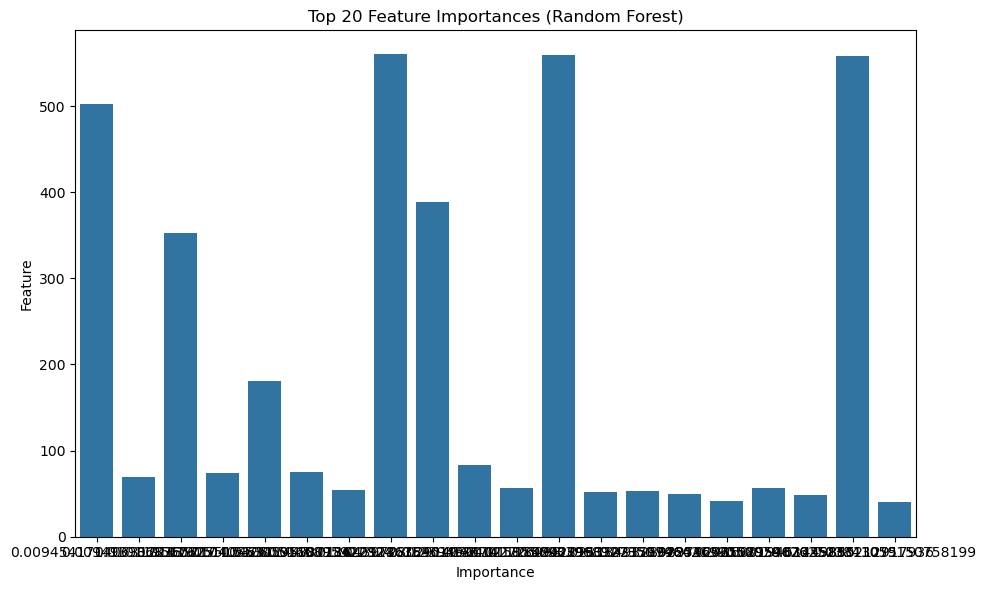

In [77]:
importances = rf_model.feature_importances_  # or use xgb.feature_importances_ for XGBoost
feature_names = X.columns

# Top 20 important features
importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
top_features = importances_df.sort_values(by='Importance', ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_features, x='Importance', y='Feature')
plt.title("Top 20 Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()


## Train an SVM (Support Vector Machine) Model
Great for high-dimensional datasets like HAR

In [79]:
from sklearn.svm import SVC

In [80]:
# Train SVM
svm_model = SVC(kernel="rbf", C=1.0, random_state=42)
svm_model.fit(X_train, y_train)

SVC(random_state=42)

In [81]:
# Predict
y_pred_svm = svm_model.predict(X_test)

In [82]:
accuracy_score(y_test, y_pred_svm)

0.9737864077669903

In [83]:
report_dict = classification_report(y_test, y_pred_svm, output_dict=True)

report_df = pd.DataFrame(report_dict).transpose()

report_df

,precision,recall,f1-score,support
0,0.992647,0.997537,0.995086,406.000000
1,0.929319,0.941645,0.935441,377.000000
2,0.945087,0.923729,0.934286,354.000000
3,0.994595,0.997290,0.995940,369.000000
4,0.992958,0.992958,0.992958,284.000000
5,0.996296,0.996296,0.996296,270.000000
accuracy,0.973786,0.973786,0.973786,0.973786
macro avg,0.975150,0.974909,0.975001,2060.000000
weighted avg,0.973754,0.973786,0.973741,2060.000000


## ROC & Precision-Recall Curve (One-vs-Rest)

C:\Users\Kajal\anaconda3\envs\py_env\lib\site-packages\sklearn\metrics\_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


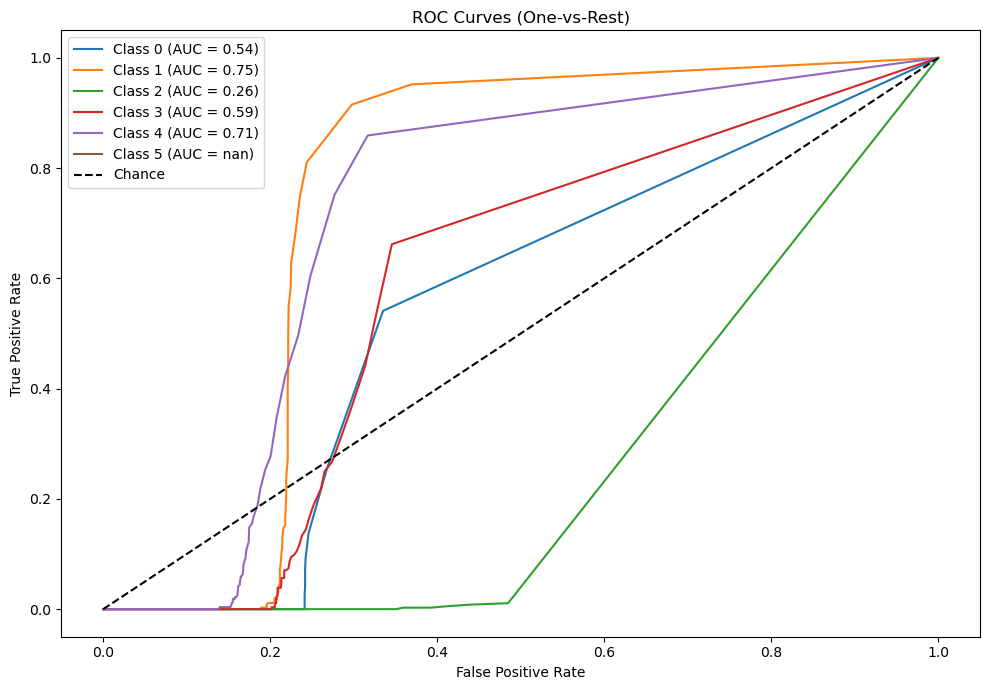

In [85]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import numpy as np

# Binarize the output
y_test_bin = label_binarize(y_test, classes=np.unique(y))
n_classes = y_test_bin.shape[1]

# Train a classifier for probabilities (e.g., Random Forest)
y_score = rf_model.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 7))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.title("ROC Curves (One-vs-Rest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.show()


## Compare Model Performance
compare the accuracy of all models to see which one performs best

In [87]:
print("Model Performance Comparison:")
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"SVM Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")


Model Performance Comparison:
Logistic Regression Accuracy: 0.9825
Random Forest Accuracy: 0.9772
SVM Accuracy: 0.9738


## Model Export 

In [89]:
import joblib

# Save best model (e.g., Random Forest)
joblib.dump(rf_model, "random_forest_model.pkl")
print("Model saved as 'random_forest_model.pkl'")


Model saved as 'random_forest_model.pkl'


## Hyperparameter Tuning
To improve performance, we can tune hyperparameters using Grid Search

In [91]:
from sklearn.model_selection import GridSearchCV

In [92]:
# Define parameter grid
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20],
}

In [93]:
# Grid search
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring="accuracy")

In [94]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None, 10, 20],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [95]:
# Best parameters
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'max_depth': 20, 'n_estimators': 200}


In [96]:
best_rf = grid_search.best_estimator_

In [97]:
y_pred_best_rf = best_rf.predict(X_test)

In [98]:
accuracy_score(y_test, y_pred_best_rf)

0.9781553398058253

## Reshape Data for Deep Learning
Deep Learning models expect 3D input : (samples, time steps, features)

In [100]:
# Reshape data to 3D (samples, timesteps, features)
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [101]:
print("Reshaped Train :",X_train_reshaped,"\n","Reshaped Test :",X_test_reshaped)

Reshaped Train : [[[ 0.01009825]
  [-0.82048542]
  [ 0.07422204]
  ...
  [-0.56761665]
  [ 0.59284711]
  [ 0.34178178]]

 [[-0.1342673 ]
  [-0.58690647]
  [ 1.00513021]
  ...
  [-0.52334525]
  [ 0.63802431]
  [ 0.38859702]]

 [[ 0.06464445]
  [ 0.03760201]
  [ 0.06210807]
  ...
  [-0.21894317]
  [-0.73388991]
  [-0.06231846]]

 ...

 [[ 0.2898165 ]
  [-0.01609873]
  [-0.20726007]
  ...
  [-0.70429867]
  [ 0.39381595]
  [ 0.07194786]]

 [[ 0.09060944]
  [-0.0332004 ]
  [-0.09110674]
  ...
  [-0.67139306]
  [ 0.0593638 ]
  [-0.16358644]]

 [[-0.15919509]
  [ 0.66453611]
  [ 0.25655581]
  ...
  [-0.72695516]
  [ 0.40913238]
  [ 0.21209183]]] 
 Reshaped Test : [[[ -1.06464472]
  [ -0.10703847]
  [ -0.05517705]
  ...
  [ -0.67974928]
  [  0.40782821]
  [  0.03549684]]

 [[  0.12520769]
  [  0.02847704]
  [ -0.02034182]
  ...
  [  2.13150999]
  [ -2.09290596]
  [ -1.39034273]]

 [[ -0.02689144]
  [ -0.08647551]
  [ -0.10460878]
  ...
  [ -0.36950836]
  [  0.77307754]
  [ -0.04167985]]

 ...


## Train an LSTM Model
LSTMs are great for time-series data

In [103]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [104]:
# Define LSTM model
lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(32),
    Dropout(0.5),
    Dense(6, activation='softmax')  # 6 classes of activities
])

In [105]:
# Compile
lstm_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [106]:
# Train
lstm_model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_data=(X_test_reshaped, y_test))

Epoch 1/10


258/258 [==============================] - 110s 402ms/step - loss: 1.1953 - accuracy: 0.3882 - val_loss: 1.0119 - val_accuracy: 0.5689
Epoch 2/10
258/258 [==============================] - 138s 534ms/step - loss: 0.8772 - accuracy: 0.6132 - val_loss: 0.7268 - val_accuracy: 0.6801
Epoch 3/10
258/258 [==============================] - 122s 473ms/step - loss: 0.7725 - accuracy: 0.6759 - val_loss: 0.6035 - val_accuracy: 0.7568
Epoch 4/10
258/258 [==============================] - 122s 472ms/step - loss: 0.6126 - accuracy: 0.7505 - val_loss: 0.5430 - val_accuracy: 0.7840
Epoch 5/10
258/258 [==============================] - 132s 513ms/step - loss: 0.7935 - accuracy: 0.6649 - val_loss: 0.6383 - val_accuracy: 0.7335
Epoch 6/10
258/258 [==============================] - 122s 471ms/step - loss: 0.6504 - accuracy: 0.7285 - val_loss: 0.5582 - val_accuracy: 0.7684
Epoch 7/10
258/258 [==============================] - 118s 456ms/step - loss: 0.5737 - accuracy: 0.7625 - val_loss: 0.4988

In [107]:
# Evaluate
test_loss, test_acc_LSTM = lstm_model.evaluate(X_test_reshaped, y_test)
test_acc_LSTM

65/65 [==============================] - 9s 136ms/step - loss: 0.4647 - accuracy: 0.8117


0.8116505146026611

## Train a CNN Model
CNNs are useful for feature extraction from sensor data.

In [109]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

In [110]:
# Define CNN model
cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')
])

In [111]:
# Compile
cnn_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [112]:
# Train
cnn_model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_data=(X_test_reshaped, y_test))

Epoch 1/10
258/258 [==============================] - 9s 29ms/step - loss: 0.5515 - accuracy: 0.7796 - val_loss: 0.1558 - val_accuracy: 0.9413
Epoch 2/10
258/258 [==============================] - 7s 27ms/step - loss: 0.2410 - accuracy: 0.9107 - val_loss: 0.0992 - val_accuracy: 0.9592
Epoch 3/10
258/258 [==============================] - 7s 28ms/step - loss: 0.1836 - accuracy: 0.9286 - val_loss: 0.0787 - val_accuracy: 0.9704
Epoch 4/10
258/258 [==============================] - 7s 28ms/step - loss: 0.1417 - accuracy: 0.9455 - val_loss: 0.0704 - val_accuracy: 0.9718
Epoch 5/10
258/258 [==============================] - 7s 28ms/step - loss: 0.1276 - accuracy: 0.9544 - val_loss: 0.0643 - val_accuracy: 0.9704
Epoch 6/10
258/258 [==============================] - 7s 28ms/step - loss: 0.1126 - accuracy: 0.9568 - val_loss: 0.0515 - val_accuracy: 0.9811
Epoch 7/10
258/258 [==============================] - 7s 28ms/step - loss: 0.0899 - accuracy: 0.9631 - val_loss: 0.0545 - val_accuracy: 0.9777

In [113]:
# Evaluate
test_loss, test_acc_CNN = cnn_model.evaluate(X_test_reshaped, y_test)
test_acc_CNN

65/65 [==============================] - 1s 11ms/step - loss: 0.0522 - accuracy: 0.9801


0.9800971150398254

## Compare Deep Learning Models

In [115]:
print(test_acc_LSTM)
print(test_acc_CNN)

0.8116505146026611
0.9800971150398254


## Save model

In [117]:
cnn_model.save("har_cnn_model.keras")

In [118]:
cnn_model.save("har_cnn_model.h5")

C:\Users\Kajal\anaconda3\envs\py_env\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Convert TensorFlow Model to TensorFlow Lite
for lightweight models.
best for Mobile, embedded devices.

In [120]:
import tensorflow as tf

# Load model
model = tf.keras.models.load_model("har_cnn_model.h5")

# Convert to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save to file
with open("har_model.tflite", "wb") as f:
    f.write(tflite_model)

print("TFLite model saved as har_model.tflite")


INFO:tensorflow:Assets written to: C:\Users\Kajal\AppData\Local\Temp\tmpzp918n7t\assets


INFO:tensorflow:Assets written to: C:\Users\Kajal\AppData\Local\Temp\tmpzp918n7t\assets


TFLite model saved as har_model.tflite


## Convert TensorFlow/Keras Model to ONNX
for lightweight models.
best for Cross-framework compatibility.

In [122]:
# !pip install keras2onnx onnx


In [123]:
import tensorflow as tf
import tf2onnx

# Load your Keras model
model = tf.keras.models.load_model("har_cnn_model.keras")

# Match the input shape your model is built for
spec = (tf.TensorSpec([None, 561, 1], tf.float32, name="input"),)

# Convert the model
onnx_model, _ = tf2onnx.convert.from_keras(model, input_signature=spec, opset=13)

# Save the ONNX model
with open("har_model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())


In [124]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 559, 64)           256       
                                                                 
 max_pooling1d (MaxPooling1  (None, 279, 64)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 277, 32)           6176      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 138, 32)           0         
 g1D)                                                            
                                                                 
 flatten (Flatten)           (None, 4416)              0         
                                                                 
 dense_1 (Dense)             (None, 64)               

## TFLite to test predictions

In [126]:
import numpy as np
import tensorflow as tf

# Load TFLite model
interpreter = tf.lite.Interpreter(model_path="har_model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Prepare sample input
input_data = X_test_reshaped[0:1].astype(np.float32)  # shape: (1, timesteps, 1)
interpreter.set_tensor(input_details[0]['index'], input_data)

# Run inference
interpreter.invoke()
prediction = interpreter.get_tensor(output_details[0]['index'])
predicted_class = np.argmax(prediction)
print("Predicted class:", predicted_class)


Predicted class: 3


## FastAPI Project

In [129]:
from fastapi import FastAPI, File, UploadFile
import pandas as pd
import numpy as np
from io import StringIO
import tensorflow as tf  

app = FastAPI()

# Load your model here
model = tf.keras.models.load_model("har_cnn_model.h5") 

@app.post("/predict")
async def predict(file: UploadFile = File(...)):
    try:
        # Read and decode the uploaded file
        contents = await file.read()
        data = pd.read_csv(StringIO(contents.decode("utf-8")))

        # Debug: print original shape
        print("Original data shape:", data.shape)

        # Dynamically reshape data
        num_samples = data.shape[0] * data.shape[1]
        reshaped_data = data.values.reshape(1, num_samples, 1).astype(np.float32)

        # Make prediction
        prediction = model.predict(reshaped_data)
        predicted_class = int(np.argmax(prediction))

        return {"predicted_activity_class": predicted_class}

    except Exception as e:
        print("Prediction error:", e)
        return {"error": str(e)}


In [130]:
uvicorn.run(app, host="127.0.0.1", port=8001)

INFO:     Started server process [22068]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8001 (Press CTRL+C to quit)
INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [22068]
